# Traffic Sign Recognition with CNN

## Introduction: The Dataset

For this project I have decided to tackle the traffic sign recognition dataset from Kaggle. A set of 877 images of traffic signs, each being labeled in a certain category. For the simplicity of the task, all images have been broken down to **4 categories**:
- trafficlight
- crosswalk
- stop
- speedlimit

The downloaded data is presented as follow:
1. Images - saved as PNG images in the `images` folder
2. Labels - saved as XML files, along with image metadata, in the `annotations` folder

Link to the dataset: https://www.kaggle.com/datasets/andrewmvd/road-sign-detection

## Strategy and Results

For the classification, I decided to use a *Convolutional Neural Network*(CNN) with the **Tensorflow** framework.
My best attempt with the base dataset was an *80% validation accuracy*, but through data augumentation, I reached *85%*.

In [47]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [48]:
# check directory contents
os.listdir()

['.ipynb_checkpoints', 'annotations', 'images', 'traffic.ipynb']

For reading the images from the `images` folder, PIL library was used.
Images are in **RGBA** format, but for better balance in the model, I converted to **RGB**.
Every image has a different dimension, to make the training work, I have decided to stick with a 100*100 resolution.

Images are then saved as `numpy` arrays and added to a list. **Data augumentation** was done by saving the horizontal flip of the base image to squeeze more information from the model, thus doubling the number of data.

In [49]:
images = []
rotated_images = []

# open every image, convert to rgb and standardize the size
for img in os.listdir('images'):

    image = Image.open(os.path.join('images', img))

    images.append(np.array(image.convert('RGB').resize((100, 100))))
    rotated_images.append(np.array(image.convert('RGB').resize((100, 100)).transpose(Image.ROTATE_180)))

# check that the dataset was saved correctly
len(images)

877

In [50]:
# Save the complete list of images and convert to numpy array
images = np.array(images + rotated_images)

images.shape

(1754, 100, 100, 3)

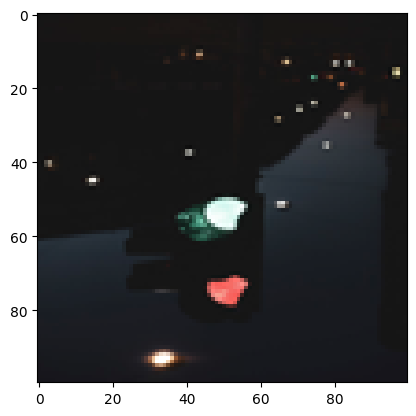

In [51]:
# Check a sample image
plt.imshow(rotated_images[0])
plt.show()

Each images's label is saved in the `annotations` folder as an XML. The `xml` library will be used to extract the *name* field, containing the explicit label of the given image and then they are added to the list of labels.

In [52]:
import xml.etree.ElementTree as ET

labels = []

# Read labels from xml files
for name in os.listdir('annotations'):
    tree = ET.parse(os.path.join('annotations', name))
    root = tree.getroot()

    element = root.findall('.//name')[0]
    label = element.text
    labels.append(label)

# Check if all labels were read correctly
len(labels)

877

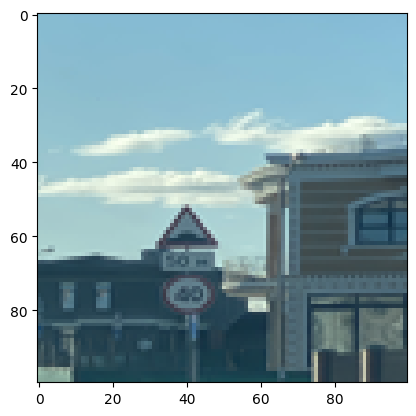

speedlimit


In [53]:
from random import randint

# Print a random image and the corresponding label
index = randint(1, len(labels))
plt.imshow(images[index])
plt.show()
print(labels[index])

To easily encode the text labels, a set of all labels is created to save every unique appearance and encoded by their index within the set. Keep in mind that the image dataset was populated with the flipped images by half. To correctly treat this, the same list of encoded labels is concatenated with itself, before being converted to a `numpy` array.

In [54]:
categories = list(set(labels))
print(categories)

# encode labels with their index in set and convert to numpy array
labels = [categories.index(label) for label in labels]
labels = np.array(labels + labels) # double for rotated images

['trafficlight', 'crosswalk', 'speedlimit', 'stop']


In [55]:
# Normalize data and split into testing and training
X_train, X_test = images[:1200] / 255.0, images[1200:] / 255.0
y_train, y_test = labels[:1200], labels[1200:]

print(X_test.shape, y_test.shape)

(554, 100, 100, 3) (554,)


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

After all handy imports were completed, it's time to decide on the CNN's architecture.

A `Sequential` model was chosen for the classic feed-forward mechanism, perfect for image classifications. 6 different types of layers have been chosen for this model:

- `Input`: for  the desired input shape of our array.
- `Conv2D`: the convolutional layers that sweep through the pixels and apply filters. A 3*3 window size was chosen, leaving the same size of the base image. For the first layer 32 nodes are used and for the second one we are using 64. The activation functions for every type of neuron will be `relu`.
- `MaxPooling2D`: will get the max value of every 2*2 grid from the image and convert it to a single pixel, thus halving the size of the image.
- `Flatten`: to convert the image to a 1D array for the dense layers.
- `Dense`: a 64 node layer with relu activation for the processing of the input data and a 4 node layer with a `softmax` function to classify the images into the 4 categories.
- `Dropout`: Randomly disables neurons in the 64 dense layer to prevent overfitting with a probability of 50%.

In [56]:
model = Sequential([
    Input((100, 100,3)),

    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense((64), activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

In [57]:
# Early Stopping callback used to stop training if plateau is reached and to save best params
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compiled with adam optimizer for best efficiency and SCC to properly handle integer typed labels
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train for 50 epochs and keep track of validation data for each feed
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[es])

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.6513 - loss: 1.3007 - val_accuracy: 0.7942 - val_loss: 0.6799
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.7487 - loss: 0.8720 - val_accuracy: 0.7978 - val_loss: 0.6084
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.7510 - loss: 0.7502 - val_accuracy: 0.8123 - val_loss: 0.5739
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.7752 - loss: 0.6968 - val_accuracy: 0.8339 - val_loss: 0.5684
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.7814 - loss: 0.6769 - val_accuracy: 0.8502 - val_loss: 0.5162
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.8055 - loss: 0.5821 - val_accuracy: 0.8285 - val_loss: 0.5357
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.8317 - loss: 0.4843 - val_accuracy: 0.8484 - val_loss: 0.5269
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.8510 - loss: 0.4142 - val_accuracy: 0.

In [58]:
# Check best params on validation set one more time
model.evaluate(X_test, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8708 - loss: 0.4381


[0.5162391662597656, 0.8501805067062378]

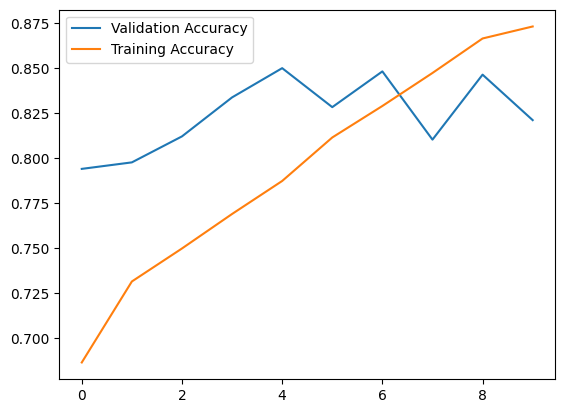

In [59]:
# Plot accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.legend()

plt.show()

## Conclusions

It seems the validation accuracy is from the start good, that being given a very small dataset, even after the augumentation. I am overall pleased with the results of this project, but there is evident room for improvement. What I can improve for the future is the standardization of the data's size, some images becoming blurred after the transposition and it would be a good idea to try more advanced data augumentaion techniques in the future.

Thank you for reading and I hope you enjoyed my work :^)